In [54]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
from IPython.display import Image
from IPython.core.display import HTML 

sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity=3
#verbosity: errors (0), warnings(1), info(2), hints(3)
sc.logging.print_versions()
#the file that will store analysis results
results_file='Users/caroline/Desktop/Hashing_analysis/write/Hashing_results.h5ad' 

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


For my dataset I will be using data from Single Cell RNA sequencing (which I do for work). This data is from one of our validation experiments for a process called Cell Hashing.  Essentially we "tagged" 8 different samples with unique antibody "barcodes" (unique DNA sequences to ID samples). We combined all 8 samples into a single tube to run through the process. (The main benefits from this are eliminating batch effects and reducing reagent costs 8-fold). 

A schematic diagram of the process is shown below (only showing 3 samples rather than 8).

In [55]:
Image(url= "https://citeseq.files.wordpress.com/2018/02/cell_hashing.png?w=1400")

We then isolate and purify the DNA from the samples. After we clean up the DNA from other "junk" molecules, we amplify it using PCR using unique sample indexes (unique DNA sequences to ID our samples) and specific DNA primers that are compatible with the sequencing machine.  We load our DNA libraries onto the sequencer and each base is read one at a time. The output is a raw BCL file containing the bases (A, G, C or T) detected for each DNA strand. 

If you are interested in learning more about DNA sample prep & sequencing technology, here is a quick 5-minute video that breaks it down nicely: https://www.youtube.com/watch?v=fCd6B5HRaZ8

After obtaining our BCL file containing all of our DNA sequence reads, we run it through a sophisticated pipeline called Cell Ranger. This pipeline aligns our DNA sequences to a reference human genome to figure out which (and how many) genes were detected. The pipeline also "demultiplexes" our data to identify from which cell every read originated from. Then, using the sequences of the antibody barcodes that we began our experiment with (these unique sequences can be found within our DNA reads), it can assign every cell back to each of the original 8 samples. 

The output of this pipeline is a gene expression matrix in which rows represent genes and columns represent individual cells. Each element of the matrix represents the number of times a gene was detected (aka the gene count) in a particular cell. In other words, this count matrix represents the expression levels of every gene one cell at a time. It also contains additional annotations to identify each cell back to its original sample. 

The final output is an annotated data matrix called an AnnData matrix. It is part of the AnnData class that was built specifically for single cell sequencing (https://icb-anndata.readthedocs-hosted.com/en/stable/anndata.AnnData.html). Conveniently these objects were designed to be handled and spliced similar to pandas DataFrames. 

At its core, an AnnData object stores a data matrix "X", which is our count matrix as described above. The columns are paired with a variables matrix ("var") where each variable/column represents a unique gene, and the rows are paired with an observations matrix ("obs") where each observation/row represents an individual cell. 

There is a fourth (and less important) matrix for unstructured annotations ("uns"), which contains reads that did not align to any genes (these are called orphaned reads).

In [56]:
Image(url= "https://falexwolf.de/img/scanpy/anndata.svg")

As a computational biologist it would be my job to load this AnnData object into Python and assess whether it looks the way we expect it to. I used this tutorial to guide my initial analysis: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

First we need to load in the data:

In [57]:
#read in our data
adata=anndata.read_h5ad('/Users/caroline/Desktop/Hashed_analysis/Hashed_secondary_output_Hashed_Hashed_demux.h5ad')
adata

AnnData object with n_obs × n_vars = 70351 × 33538 
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment'
    var: 'gene_ids', 'robust'
    uns: 'background_probs', 'genome'
    obsm: 'raw_probs'

We see that our AnnData object, adata, contains 70,351 observations (in other words there were 70,351 cells detected) and 33,538 variables (in other words 33,538 genes were detected).

We see that our observations matrix .obs contains the following attributes:

Channel: The machine we use for sample prep has 8 channels, and this tells you which one your sample was run in. In this case this value is unimportant (we ran all of our samples through a single channel - that's the point of cell hashing, to minimize batch effects between different channels).

    n_genes: total genes detected within one cell

    n_counts: the number of times each read occured (remember, we amplified our DNA, so there are multiple copies of the same read)

    demux_type: As a bit of background, the technology used actually uses microscopic oil-water droplets to isolate single cells. The pipelines used can detect whether a droplet contained one, two or three cells - represented by the values "singlet", "doublet" (containing 2 or more cells), or "unknown"

    assignment: This tells us which original sample the cell belongs to.

The variables matrix contains:

    gene_ids: The abbreviated name for each gene

    robust: not sure?

Let's take a look at our observations matrix to see how the demultiplexing worked.

In [58]:
samp=adata.obs
samp

,Channel,n_genes,n_counts,demux_type,assignment
index,,,,,
AAACCCAAGACAACTA,,368,536.0,doublet,"A375_15,A375_13,HEK_10"
AAACCCAAGACGGTTG,,347,491.0,doublet,"HEK_8,A375_15"
AAACCCAAGAGAATCT,,317,472.0,unknown,
AAACCCAAGAGCTTTC,,352,509.0,unknown,
AAACCCAAGATACAGT,,369,534.0,unknown,
...,...,...,...,...,...
TTTGTTGTCGTCGACG,,257,325.0,unknown,
TTTGTTGTCTCCAATT,,285,367.0,unknown,
TTTGTTGTCTCGAGTA,,260,330.0,singlet,HEK_10


On the left we see the index, which is the unique sequence (our antibody "barcode") that was used to ID each read. We cab see the number of genes detected within each read, the number of times this read appeared (the count), the demultiplex type (whether there was 1 or more cells per droplet (we only want one cell per droplet - this is single cell sequencing after all). We can also see the "assignment", the sample from which each read originated from.

More background: In this experiment we used 2 cell lines, A375 (melanoma) and HEK (kidney). We split each cell line into 4 different samples and tagged them with a unique antibody to ID them later on. To name our samples we simply used the cell line followed by the antibody number that was on the tube.

Our samples are: HEK 2, 8, 10, 12, and A375 9, 13, 14, 15.

Now let's sort our reads by their assignment. If our experiment worked, we will see our 8 samples listed at the top with the highest number of reads.

In [59]:
samp.assignment.value_counts().head(25)

                   31871
HEK_8               5818
HEK_2               3739
HEK_12              3639
HEK_10              3119
A375_14             2996
A375_13             2272
A375_15             1860
A375_9              1474
HEK_8,A375_13        719
HEK_8,HEK_10         607
HEK_8,A375_14        563
HEK_8,HEK_12         505
A375_14,HEK_8        460
HEK_8,A375_15        458
HEK_10,HEK_8         445
HEK_12,HEK_8         376
A375_13,HEK_8        301
HEK_10,A375_13       264
HEK_12,A375_13       263
HEK_2,HEK_8          236
A375_14,A375_13      230
HEK_8,A375_9         225
A375_15,HEK_8        223
HEK_10,HEK_12        220
Name: assignment, dtype: int64

As expected, we see that all 8 of our samples are at the top!

We also see that there are a high rate of doublets. This is a sign that we loaded our instrument at too high of a concentration - by over-saturating the machine, you increase your chances that every droplet will have more than 1 cell. 

We will want to filter out anything that is not a singlet:

In [60]:
#filter out doublets, triplets & unknowns
adata=adata[adata.obs['demux_type']=='singlet']
adata

View of AnnData object with n_obs × n_vars = 24917 × 33538 
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment'
    var: 'gene_ids', 'robust'
    uns: 'background_probs', 'genome'
    obsm: 'raw_probs'

We see that we actually only has 24,917 single cells detected. 

Now we're going to do a bit more digging. First let's look at the genes that are most present:

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


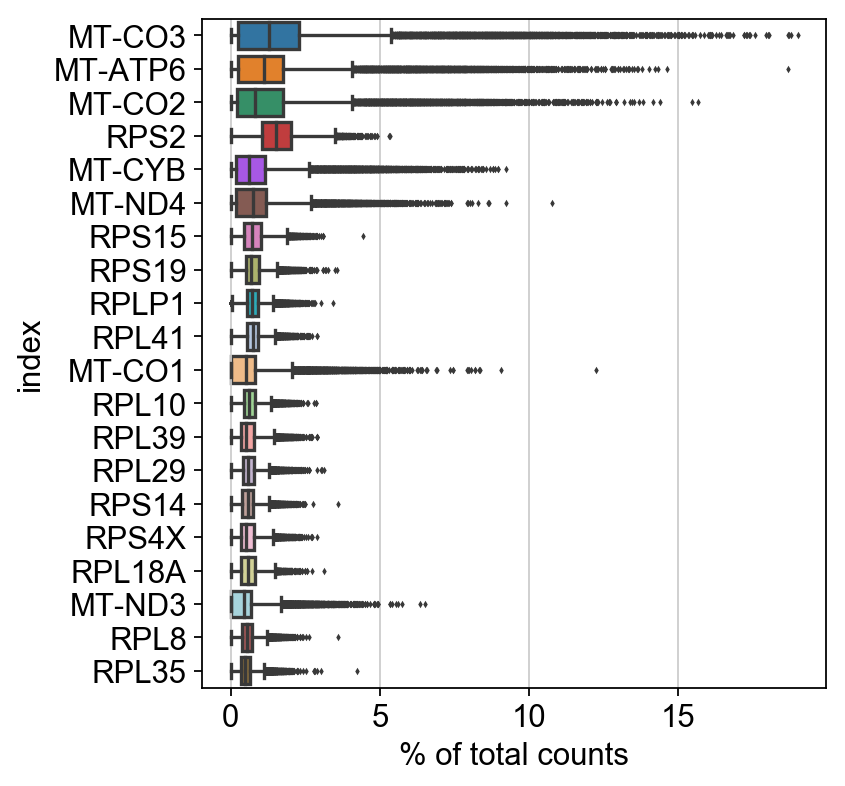

In [61]:
sc.pl.highest_expr_genes(adata, n_top=20)

Now we want to do a bit of filtering. First we will filter out any cells that had 200 or fewer genes (these are likely dead cells). We will also filter out any genes that are present in 3 or fewer cells (these are anomolies and should be excluded).
To do this we will use built-in functions from the scanpy package.

In [62]:
#filtering out low genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 91 cells that haveless than 200 genes expressed


Trying to set attribute `.obs` of view, making a copy.


filtered out 11892 genes that are detectedin less than 3 cells


There is also a built-in function that performs basic QC metrics for us. I don't really need to use these for my analysis, but it's still good to look at.

In [63]:
#calculate basic qc metrics
sc.pp.calculate_qc_metrics(adata)

(                  n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
 index                                                                        
 AAACCCAAGATAGCAT                346                 5.849325         477.0   
 AAACCCAAGCCGAATG                386                 5.958425         558.0   
 AAACCCAAGCCTCAAT               4742                 8.464425       19631.0   
 AAACCCAAGCCTCCAG                413                 6.025866         568.0   
 AAACCCAAGCTGCGAA                400                 5.993961         592.0   
 ...                             ...                      ...           ...   
 TTTGTTGGTTTAGTCG               2797                 7.936660        8334.0   
 TTTGTTGTCAGAGCGA               1487                 7.305188        3252.0   
 TTTGTTGTCCACTGAA               3075                 8.031385        9934.0   
 TTTGTTGTCCTTATGT               3503                 8.161660       11319.0   
 TTTGTTGTCTCGAGTA                260                

The next thing we want to do is filter our any mitochondrial reads.  Mitochondria (an organelle within a cell) actually have different genomes than the rest of the cell - therefore, when doing single cell research, we want to exclude the mitochondrial reads because it will confound our other findings.  

High mitochondrial reads is representative of cells that are in poor condition - sometimes cells get "stressed out" and start dying when we begin to process them. Naturally we do not want to include dead cells in our analysis, because once a cell starts to die its gene expression changes.

In [64]:
#calculate mitochondrial genes detected
mito_genes=adata.var_names.str.startswith('MT-')
#for each cell, compute fraction of counts in mito genes vs all genes
#the '.A1' is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito']=np.sum(adata[:, mito_genes].X, axis=1).A1/np.sum(adata.X, axis=1).A1
#add the total counts per cell as observations-annotation to adata
adata.obs['n_counts']=adata.X.sum(axis=1).A1

Let's take a look:

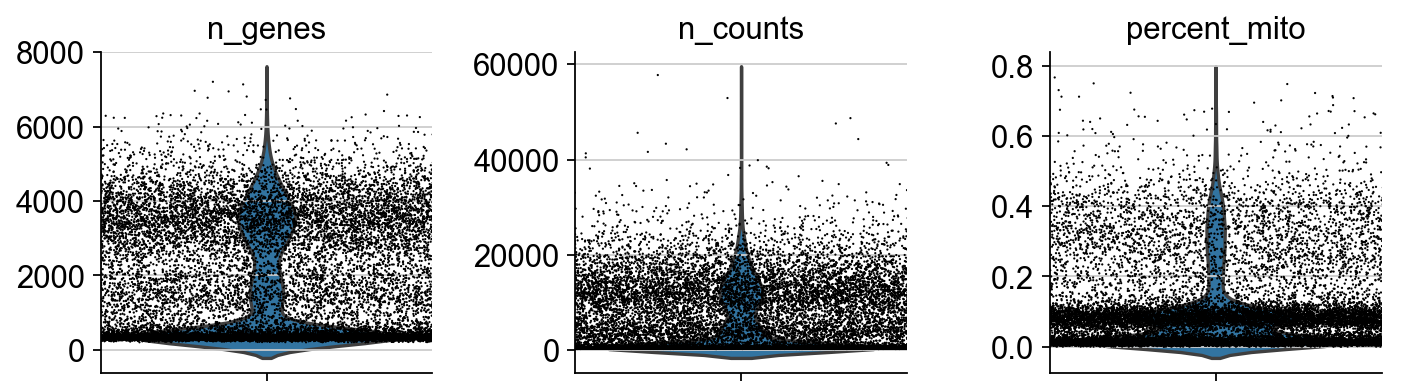

In [65]:
#a violin plot of the computed quality measures
sc.pl.violin(adata, ['n_genes','n_counts','percent_mito'], jitter=0.7, multi_panel=True)

On the left plot we see that we have a decent number of cells with ~4000 genes (which is expected for a single cell), but also a lot with almost 0 genes. We see a similar divide in the read counts: a decent amount hovers around ~18000 reads or so, but we also have a good number close to 0.  We see the same thing with % mito, as well as a lot of scattered points above 15%. Typically we want to see less than 10%) for % mito, so this is indicative that some of our cells were very stressed out & dying.

Let's plot n_genes and percent_mito against n_counts: 

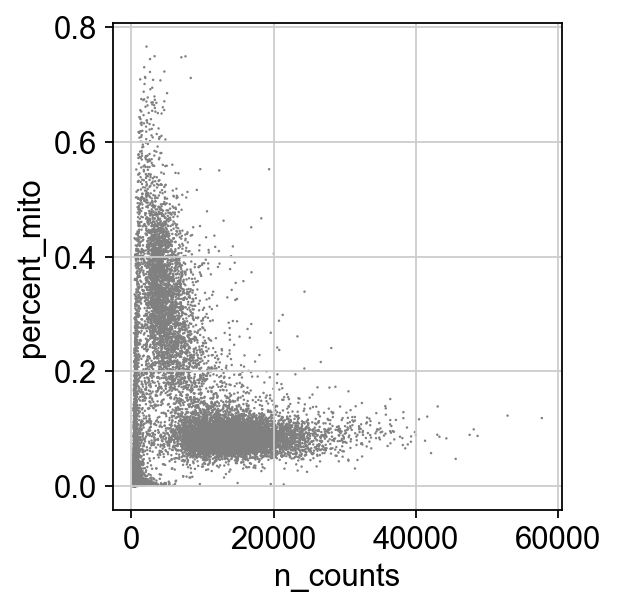

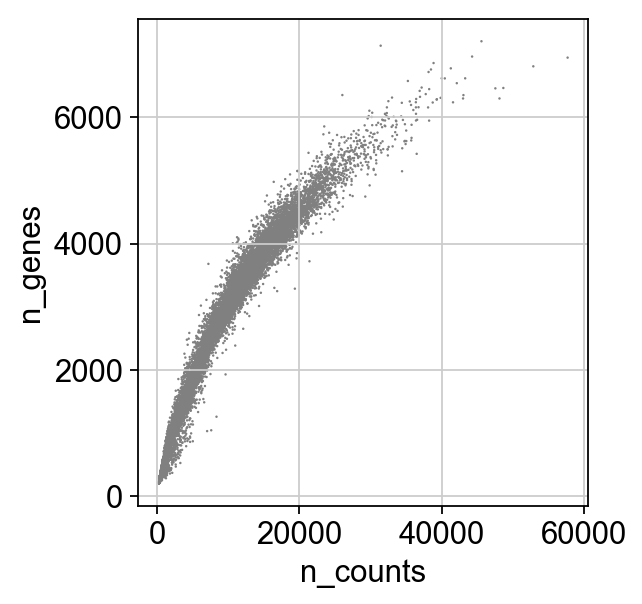

In [66]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts',y='n_genes')

In the top graph we can clearly see that there are 3 different groups: the bottom right group represents our "desired" data, where we have tens of thousands of reads per cell and a % mito of ~15%. The cluster right above that, in the middle, are our stressed out genes - not a lot of reads, and most of them were from mitochondria (because cells were stressed & dying). On the very left we see a straight-ish line with very few reads and very high % mitochondrial - these are cells that were already dead. We want to filter these last two groups out.

In the bottom graph we see that the number of genes detected increases as the number of reads detected - this is what we expect so this looks good.

In [67]:
#filter out any cells that have less than 6000 genes 
#(this is based off of our first graph - anything higher than this looks like an outlier)
adata=adata[adata.obs['n_genes']<6000, :]
#filter out any cells with over 5% mito (this filters out the very bottom left of the graph, where there are very few reads),
#and under 20% mito (to filter out our very stressed cells)
adata=adata[adata.obs['percent_mito']<0.2, :]
adata=adata[adata.obs['percent_mito']>0.05, :]
#filter out any cells with fewer than 1500 reads per cell
adata=adata[adata.obs['n_counts']>1500, :]
adata

View of AnnData object with n_obs × n_vars = 8580 × 21646 
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment', 'percent_mito'
    var: 'gene_ids', 'robust', 'n_cells'
    uns: 'background_probs', 'genome'
    obsm: 'raw_probs'

Our adata matrix now only contains data from 8580 high-quality individual cells.

Let's take a look at those scatter plots again:

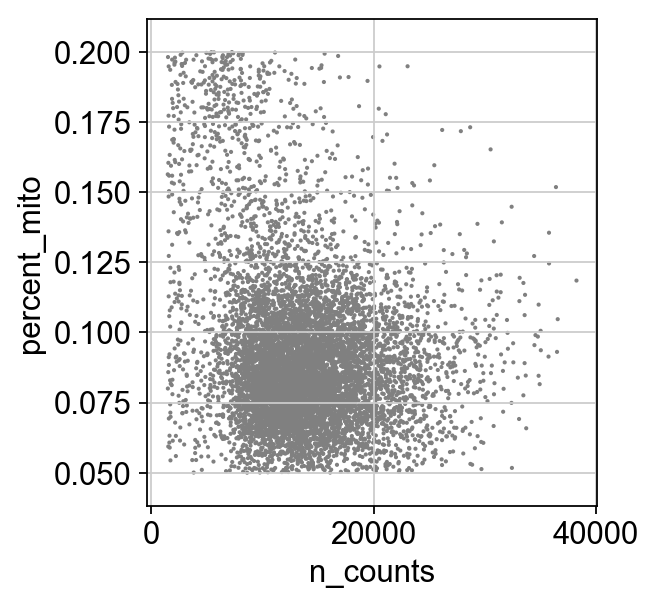

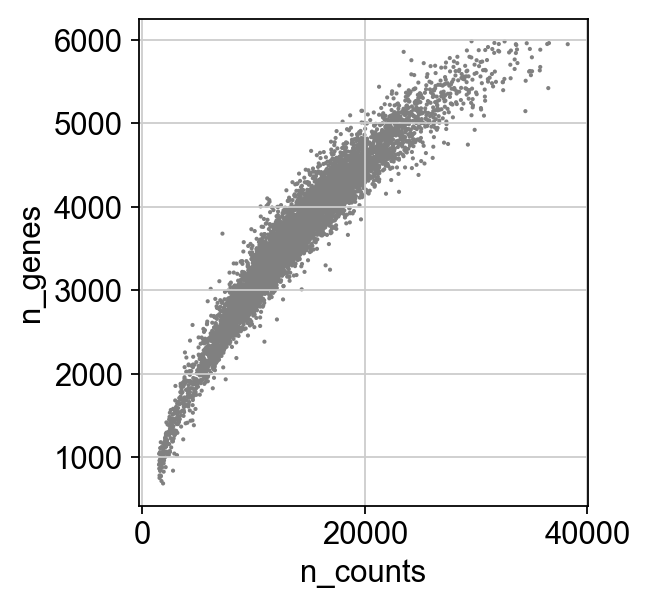

In [68]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts',y='n_genes')

Much better.

Now we are going to normalize our data to 10,000 reads per cell so that the counts become comparable among cells:

In [69]:
#total count normalize (library-size correct) the data matrix 
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


And then we logarithmize the data:

In [70]:
sc.pp.log1p(adata)

In [71]:
#set the .raw attribute of adata to the logarithmized raw gene expression 
#for later use in differential testing and visualizations of gene expression.
#This simply freezes the state of the adata object
adata.raw=adata

In [72]:
#Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


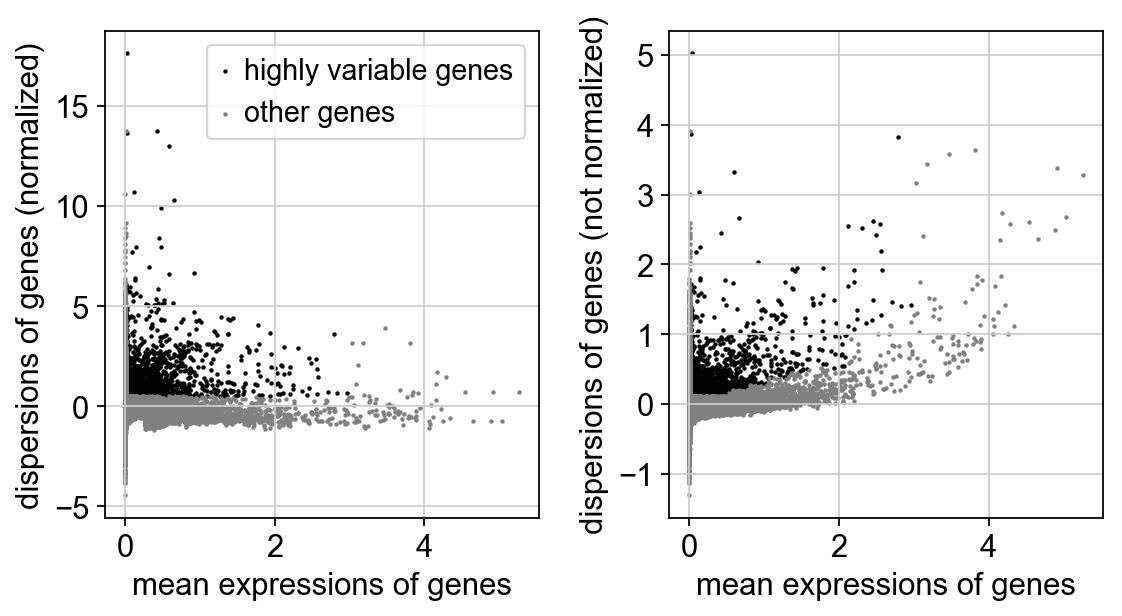

In [73]:
sc.pl.highly_variable_genes(adata)

In [74]:
#filter - not actually needed, can just flag the variable genes instead
adata=adata[:, adata.var['highly_variable']]

Regress out the effects of total counts per cell and % mito:

In [75]:
sc.pp.regress_out(adata, ['n_counts','percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:15)


Now we scale each gene to unit variance. 

In [76]:
# Clip values exceeding standard deviation 10
sc.pp.scale(adata, max_value=10)

In [77]:
#Principal component analysis to reduce dimensionality of the data
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:02)


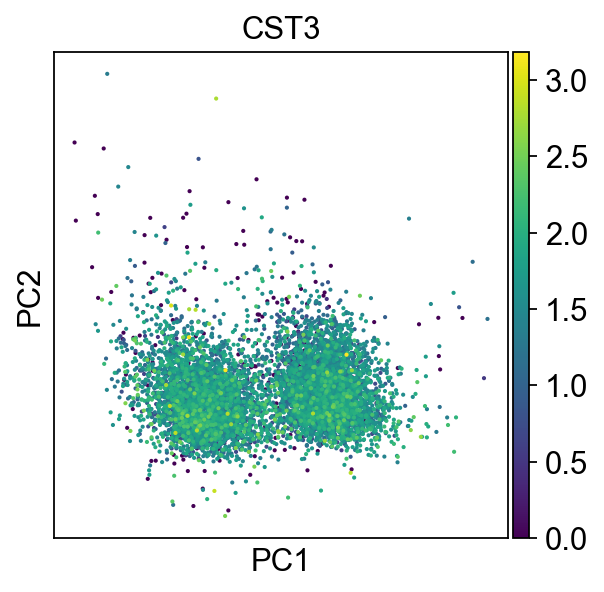

In [78]:
#scatter plot in the PCA coordinates
sc.pl.pca(adata, color='CST3')

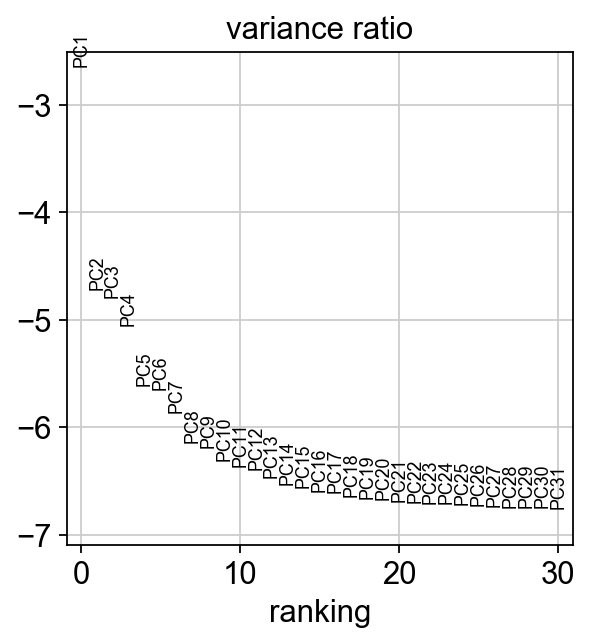

In [79]:
#Let's inspect the contribution of single PCs to the total variance in the data.
#This gives us information on how many PCs we should consider un order to compute
#the neighborhood relations of cells, eg used in the clutering function sc.tl.louvain()
#or tSNE sc.tl.tsne()

sc.pl.pca_variance_ratio(adata, log=True)

In [80]:
#save the result
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 8580 × 2203 
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment', 'percent_mito'
    var: 'gene_ids', 'robust', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'background_probs', 'genome', 'pca'
    obsm: 'raw_probs', 'X_pca'
    varm: 'PCs'

In [81]:
#Computing the neighborhood graph using the PCA representation
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40


/Users/caroline/opt/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "opt/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/caroline/opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "opt/anaconda3/lib/python3.7/site-packages/umap/utils.

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:05)


In [82]:
#Embedding the graph in 2 dimensions using UMAP
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


Clustering:

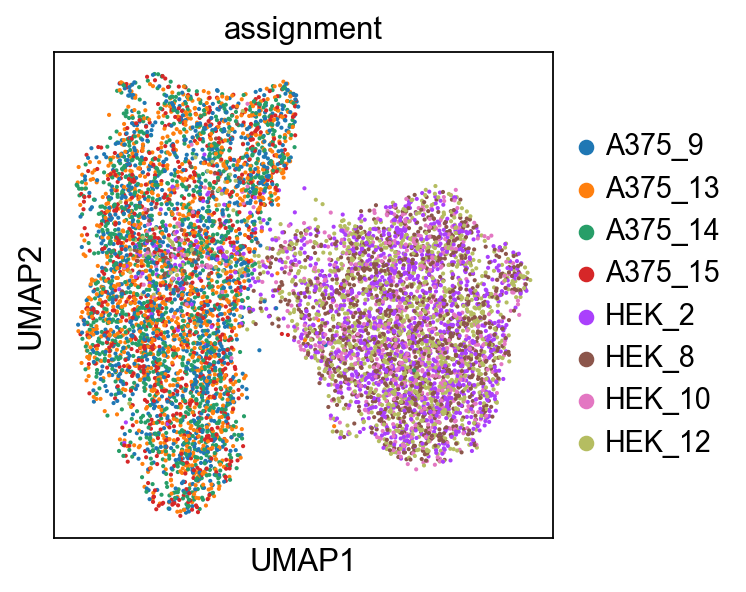

In [83]:
sc.pl.umap(adata, color=['assignment'])

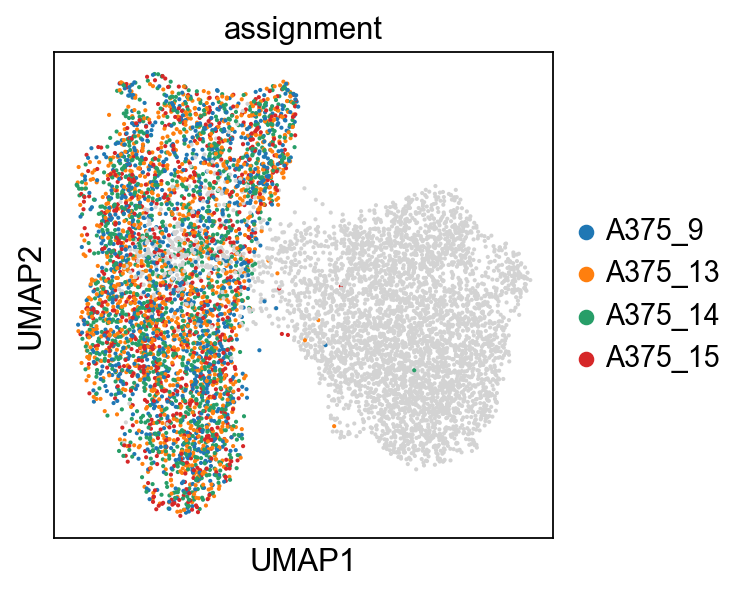

In [84]:
sc.pl.umap(adata, color=['assignment'], groups=['A375_9', 'A375_13', 'A375_14', 'A375_15'])

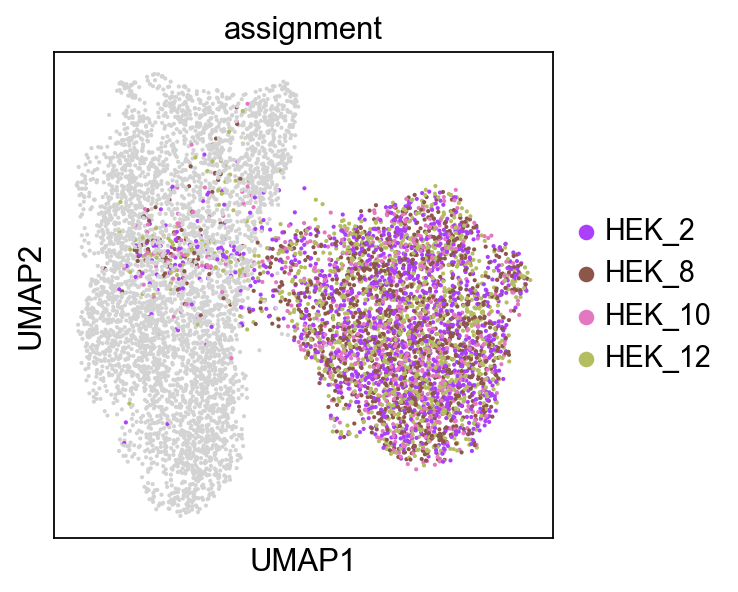

In [85]:
sc.pl.umap(adata, color=['assignment'], groups=['HEK_2', 'HEK_8', 'HEK_10', 'HEK_12'])

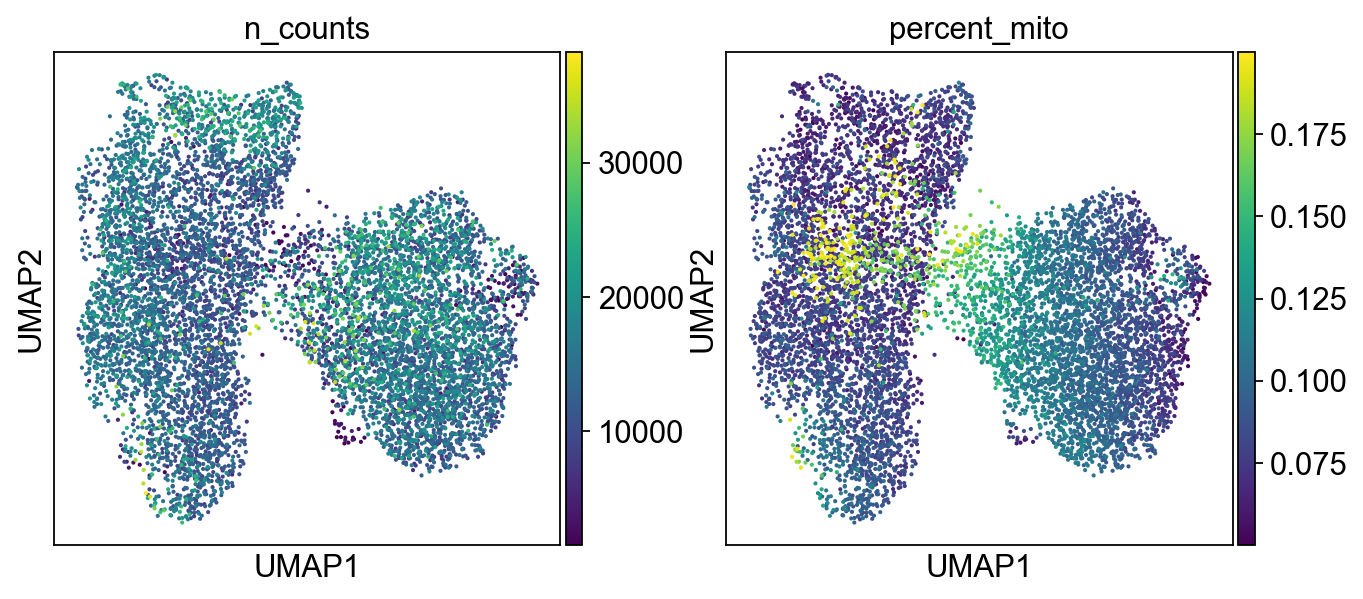

In [86]:
sc.pl.umap(adata, color=['n_counts', 'percent_mito'])

In [87]:
adata

AnnData object with n_obs × n_vars = 8580 × 2203 
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment', 'percent_mito'
    var: 'gene_ids', 'robust', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'background_probs', 'genome', 'pca', 'neighbors', 'assignment_colors'
    obsm: 'raw_probs', 'X_pca', 'X_umap'
    varm: 'PCs'